In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import talib as ta
import optuna
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

/home/kanai/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
csv_use_cols = ["Date", "Open", "High", "Low", "Close", "Volume"]
shift = 5

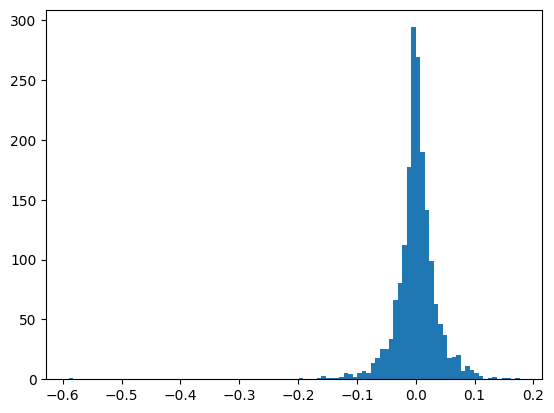

In [3]:
def twotype_label_func(x):
    if x > 0.015: return 1
    else: return 0

def multilabel_func(x):
    param2 = 0.05
    param1 = 0.02
    param0 = 0.008
    param = 0.002
    if x > param2: return 4
    elif param2 >= x > param1: return 3
    elif param1 >= x > param0: return 2
    elif param0 >= x > param: return 1
    elif param >= x > -1*param: return 0
    elif -1*param >= x > -1*param0: return -1
    elif -1*param0 >= x > -1*param1: return -2
    elif -1*param1 >= x > -1*param2: return -3
    elif x < -1*param2: return -4

df = pd.read_csv("btcjpy_data_from_yfinance-5y-1d.csv",usecols=csv_use_cols)

df["diff_ratio"] = df["Close"].diff()/df["Close"] 
plt.hist(df["diff_ratio"],bins=100)
plt.show()


droped: 3


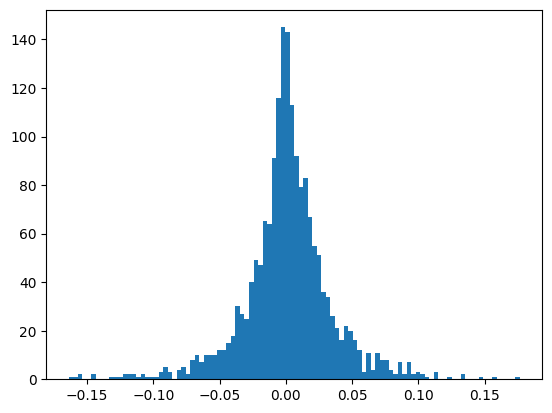

In [4]:
before_index = df.shape[0]
df = df[df["diff_ratio"]>-0.18]
print("droped:",before_index-df.shape[0])
plt.hist(df["diff_ratio"],bins=100)
plt.show()

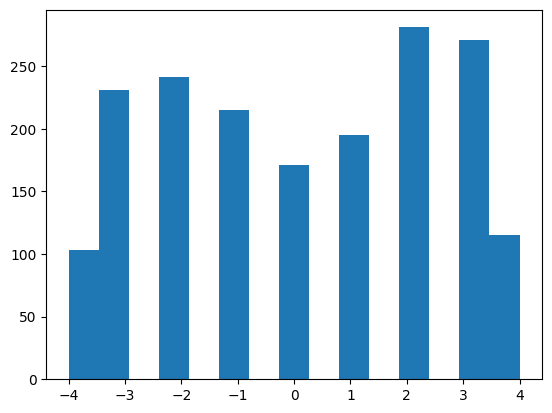

In [5]:
df["target"] = np.vectorize(multilabel_func)(df["diff_ratio"])
df["target"] = df["target"].shift(-1)

plt.hist(df["target"],bins=15)
plt.show()

In [6]:
df["EMA5"] = ta.EMA(df["Close"], timeperiod=5)
df["EMA10"] = ta.EMA(df["Close"], timeperiod=10)
df["EMA25"] = ta.EMA(df["Close"], timeperiod=25)
df["EMA50"] = ta.EMA(df["Close"], timeperiod=50)
df["EMA75"] = ta.EMA(df["Close"], timeperiod=75)
df["EMA100"] = ta.EMA(df["Close"], timeperiod=100)
df["EMA200"] = ta.EMA(df["Close"], timeperiod=200)
df["RSI"] = ta.RSI(df["Close"], timeperiod=14)
df["MFI"] = ta.MFI(df["High"], df["Low"], df["Close"], df["Volume"], timeperiod=14)

for i in range(0, shift+1):
    df["Open-{0}ratio".format(i)] = df["Open"].shift(i)/df["Close"]
    df["High-{0}ratio".format(i)] = df["High"].shift(i)/df["Close"]
    df["Low-{0}ratio".format(i)] = df["Low"].shift(i)/df["Close"]
    df["Close-{0}ratio".format(i)] = df["Close"].shift(i)/df["Close"]
    df["EMA5-{0}ratio".format(i)] = df["EMA5"].shift(i)/df["Close"]
    df["EMA10-{0}ratio".format(i)] = df["EMA10"].shift(i)/df["Close"]
    df["EMA25-{0}ratio".format(i)] = df["EMA25"].shift(i)/df["Close"]
    df["EMA50-{0}ratio".format(i)] = df["EMA50"].shift(i)/df["Close"]
    df["EMA75-{0}ratio".format(i)] = df["EMA75"].shift(i)/df["Close"]
    df["EMA100-{0}ratio".format(i)] = df["EMA100"].shift(i)/df["Close"]
    df["EMA200-{0}ratio".format(i)] = df["EMA200"].shift(i)/df["Close"]
    df["Volume-{0}".format(i)] = df["Volume"].shift(i)
    df["RSI-{0}".format(i)] = df["RSI"].shift(i)
    df["MFI-{0}".format(i)] = df["MFI"].shift(i)

df.dropna(axis=0,inplace=True)
df.reset_index(drop=True, inplace=True)

In [7]:
print(df["target"].value_counts())

mlcols = []
for i in range(0, shift+1):
    mlcols.append("Open-{0}ratio".format(i))
    mlcols.append("High-{0}ratio".format(i))
    mlcols.append("Low-{0}ratio".format(i))
    mlcols.append("Close-{0}ratio".format(i))
    mlcols.append("EMA5-{0}ratio".format(i))
    mlcols.append("EMA10-{0}ratio".format(i))
    mlcols.append("EMA25-{0}ratio".format(i))
    mlcols.append("EMA50-{0}ratio".format(i))
    mlcols.append("EMA75-{0}ratio".format(i))
    mlcols.append("EMA100-{0}ratio".format(i))
    mlcols.append("EMA200-{0}ratio".format(i))
    mlcols.append("Volume-{0}".format(i))
    mlcols.append("RSI-{0}".format(i))
    mlcols.append("MFI-{0}".format(i))

X = df[mlcols]
Y = df["target"]
print("train data")
print(X.head())

target
 3.0    246
 2.0    236
-2.0    221
-3.0    213
-1.0    192
 1.0    172
 0.0    151
 4.0     97
-4.0     91
Name: count, dtype: int64
train data
   Open-0ratio  High-0ratio  Low-0ratio  Close-0ratio  EMA5-0ratio  \
0     0.979835     1.036795    0.979835           1.0     0.997220   
1     0.979539     1.007049    0.973530           1.0     0.984018   
2     0.929565     1.005222    0.924523           1.0     0.943365   
3     0.975325     1.015415    0.971727           1.0     0.946791   
4     1.039849     1.082921    0.964053           1.0     0.989663   

   EMA10-0ratio  EMA25-0ratio  EMA50-0ratio  EMA75-0ratio  EMA100-0ratio  ...  \
0      0.992997      0.933811      0.841207      0.769676       0.713544  ...   
1      0.977003      0.920582      0.830257      0.759810       0.704351  ...   
2      0.925156      0.867131      0.781002      0.714277       0.661815  ...   
3      0.920166      0.857685      0.771154      0.704708       0.652573  ...   
4      0.964663      0

In [8]:
def objective(trial,df_X,df_y):
    params ={
        'max_depth':trial.suggest_int("max_depth",1,10),
        'min_child_weight':trial.suggest_int('min_child_weight',1,5),
        'gamma':trial.suggest_float('gamma',0,1),
        'subsample':trial.suggest_float('subsample',0,1),
        'colsample_bytree':trial.suggest_float('colsample_bytree',0,1),
        'reg_alpha':trial.suggest_float('reg_alpha',1e-5,100,log=True),
        'reg_lambda':trial.suggest_float('reg_lambda',1e-5,100,log=True),        
        'learning_rate':trial.suggest_float('learning_rate',0,1)}

    model = XGBClassifier(**params)
    
    scores = cross_val_score(model, df_X, df_y, cv=5, scoring='accuracy')
    score_mean = scores.mean()
    
    return -1 * score_mean

In [9]:
study = optuna.create_study()
study.optimize(lambda trial: objective(trial,X,Y), n_trials=200)
print("best params")
print(study.best_params)

best_params_training_data = xgb.cv(study.best_params, xgb.DMatrix(X, label=Y), num_boost_round=1000, nfold=5, metrics='auc', seed=0)
plt.plot(best_params_training_data)
plt.legend(best_params_training_data.columns)
plt.savefig("best_params_training_data.png")
plt.show()

[I 2024-01-29 17:34:54,887] A new study created in memory with name: no-name-ecf1b7cd-6126-44cb-a5eb-d65caea72702
[W 2024-01-29 17:34:54,911] Trial 0 failed with parameters: {'max_depth': 8, 'min_child_weight': 5, 'gamma': 0.21147142123783458, 'subsample': 0.4988339450989837, 'colsample_bytree': 0.7893765836270249, 'reg_alpha': 5.627957910525324, 'reg_lambda': 0.19385637873214653, 'learning_rate': 0.8473197898213513} because of the following error: ValueError('\nAll the 5 fits failed.\nIt is very likely that your model is misconfigured.\nYou can try to debug the error by setting error_score=\'raise\'.\n\nBelow are more details about the failures:\n--------------------------------------------------------------------------------\n5 fits failed with the following error:\nTraceback (most recent call last):\n  File "/home/kanai/miniconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score\n    estimator.fit(X_train, y_train, **fit_params)\n  Fi

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/kanai/miniconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kanai/miniconda3/lib/python3.11/site-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/home/kanai/miniconda3/lib/python3.11/site-packages/xgboost/sklearn.py", line 1471, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2 3 4 5 6 7 8], got [-4. -3. -2. -1.  0.  1.  2.  3.  4.]


accuracy_score
0.7876923076923077


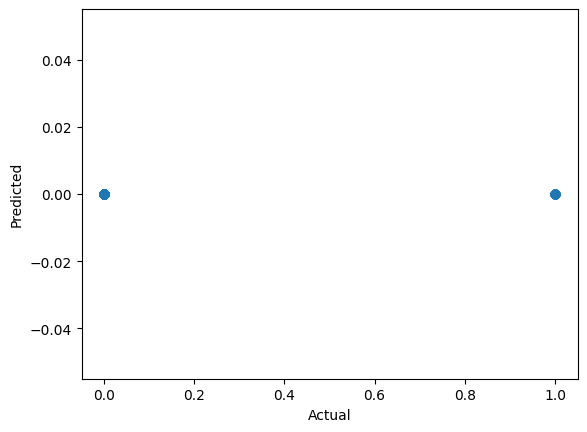

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)
model = XGBClassifier(**study.best_params)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
print("accuracy_score")
print(accuracy_score(Y_test, Y_pred))
plt.scatter(Y_test, Y_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.savefig("prediction.png")
plt.show()

<Figure size 1500x1500 with 0 Axes>

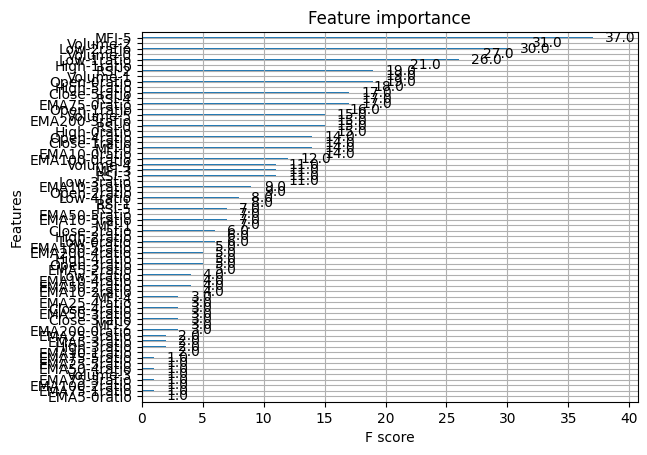

In [ ]:
fig = plt.figure(figsize=(30,30),dpi=50)
plot_importance(model)
plt.savefig("feature_importance.png")
plt.show()